## German data set

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,classification_report

In [3]:
df = pd.read_csv("Data_set/data.csv")

In [6]:
df.columns

Index(['Creditability', 'Account Balance', 'Duration of Credit (month)',
       'Payment Status of Previous Credit', 'Purpose', 'Credit Amount',
       'Value Savings/Stocks', 'Length of current employment',
       'Instalment per cent', 'Sex & Marital Status', 'Guarantors',
       'Duration in Current address', 'Most valuable available asset',
       'Age (years)', 'Concurrent Credits', 'Type of apartment',
       'No of Credits at this Bank', 'Occupation', 'No of dependents',
       'Telephone', 'Foreign Worker'],
      dtype='object')

In [13]:
X = df.drop(['Creditability'],axis = 1)
y = df['Creditability'].copy()
y[y==0] = -1
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle = True, random_state=42)

##### Random Forest

In [21]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print('accuracy_score', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

print('AUC:', roc_auc_score(y_test, y_pred))

print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(x_train, y_train),
                                                                        rf.score(x_test, y_test)))
importances=rf.feature_importances_
print('Each axis corresponds to the importance feature：\n',importances)
indices = np.argsort(importances)[::-1]# a[::-1]让a逆序输出
print('Index of the rank：\n',indices)


accuracy_score 0.7766666666666666
              precision    recall  f1-score   support

          -1       0.72      0.45      0.55        92
           1       0.79      0.92      0.85       208

    accuracy                           0.78       300
   macro avg       0.75      0.68      0.70       300
weighted avg       0.77      0.78      0.76       300

AUC: 0.6843645484949833
R^2 Training Score: 1.00 
R^2 Validation Score: 0.78
Each axis corresponds to the importance feature：
 [0.10778488 0.10774577 0.06100813 0.06337814 0.1389785  0.04686584
 0.05049883 0.04167367 0.03689298 0.01801102 0.03795056 0.04134397
 0.10743875 0.0207033  0.02518901 0.0240352  0.03161499 0.01394755
 0.02010375 0.00483518]
Index of the rank：
 [ 4  0  1 12  3  2  6  5  7 11 10  8 16 14 15 13 18  9 17 19]


In [23]:
importance = rf.feature_importances_
indices = np.argsort(importance)[::-1]
features = X.columns
for f in range(X.shape[1]):
    print(("%2d) %-*s %f" % (f + 1, 30, features[indices[f]], importance[indices[f]])))

 1) Credit Amount                  0.138978
 2) Account Balance                0.107785
 3) Duration of Credit (month)     0.107746
 4) Age (years)                    0.107439
 5) Purpose                        0.063378
 6) Payment Status of Previous Credit 0.061008
 7) Length of current employment   0.050499
 8) Value Savings/Stocks           0.046866
 9) Instalment per cent            0.041674
10) Most valuable available asset  0.041344
11) Duration in Current address    0.037951
12) Sex & Marital Status           0.036893
13) Occupation                     0.031615
14) Type of apartment              0.025189
15) No of Credits at this Bank     0.024035
16) Concurrent Credits             0.020703
17) Telephone                      0.020104
18) Guarantors                     0.018011
19) No of dependents               0.013948
20) Foreign Worker                 0.004835


No handles with labels found to put in legend.


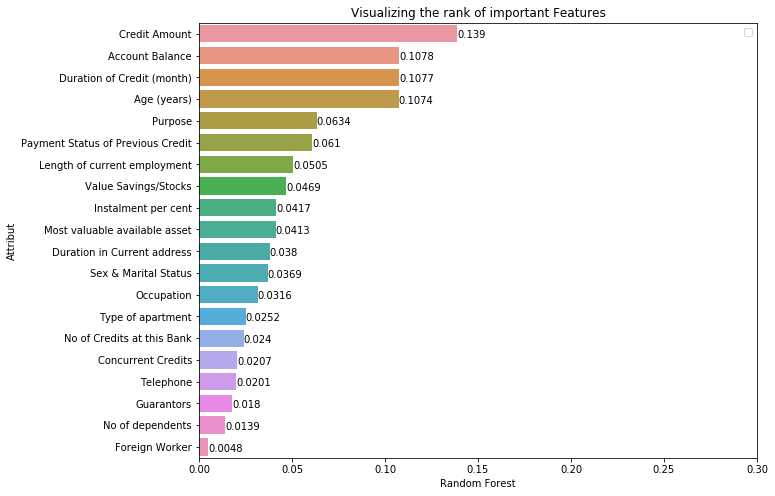

In [25]:
IV = []
for f in range(X.shape[1]):
     IV.append(importance[indices[f]])

feature_imp = []
for f in range(X.shape[1]):
     feature_imp.append(features[indices[f]])

plt.figure(figsize=(10,8))
feature_imp = pd.Series(IV,index=feature_imp).sort_values(ascending=False)

ivlist = pd.Series(IV).sort_values(ascending=False)
ivlist.values
for a,b in zip(ivlist.values,np.arange(0.2,20.2,1)):
    plt.text(a, b, round(a,4))

#plt.text(ivlist.values[0]-1, 2.2, '1.148')
sns.barplot(x=feature_imp,y=feature_imp.index)

#plt.vlines(auc_complete,feature_imp.index[19], feature_imp.index[0])
plt.xlim((0, 0.3))
#plt.ylim((0, 1))
plt.xlabel('Random Forest')
plt.ylabel('Attribut')
plt.title("Visualizing the rank of important Features")
plt.legend()
plt.show()

##### Information Value

In [26]:
def self_bin_object(X):
    d1 = pd.DataFrame({"X": X, "Y": Y,"Bucket": X})#create a DateFrame X-- attribut ， Y--label ， Bucket--each binning    
    d2 = d1.groupby('Bucket', as_index = True)# Group and aggregate according to binning results
    d3 = pd.DataFrame(d2.count(), columns = ['good'])      
    d3['good'] = d2.sum().Y    
    d3['total'] = d2.count().Y   
    d3['bad'] =  d3['total'] - d3['good']
    d3['rate'] = d2.mean().Y
    d3['woe']=np.log((d3['bad']/badnum)/(d3['good']/goodnum))# calcuate WOE of each binning
    d3['badattr'] = d3['bad']/badnum  # distribution of bad clients in each binning
    d3['goodattr'] = d3['good']/goodnum  # distribution of good clients in each binning
    iv = ((d3['badattr']-d3['goodattr'])*d3['woe']).sum()  # calculate Information VAlue
    d4 = (d3.sort_index(by ='good')).reset_index(drop=True)   # ranking 
    woe=list(d4['woe'].round(3))
    return iv,d3,woe
    

In [27]:
def self_bin_numeric(X,cut):
    d1 = pd.DataFrame({"X": X, "Y": Y,"Bucket": pd.cut(X, cut)})    
    d2 = d1.groupby('Bucket', as_index = True)
    d3 = pd.DataFrame(d2.count(), columns = ['good'])      
    d3['good'] = d2.sum().Y    
    d3['total'] = d2.count().Y   
    d3['bad'] =  d3['total']- d3['good']
    d3['rate'] = d2.mean().Y
    d3['woe']=np.log((d3['bad']/badnum)/(d3['good']/goodnum))
    d3['badattr'] = d3['bad']/badnum  
    d3['goodattr'] = d3['good']/goodnum  
    iv = ((d3['badattr']-d3['goodattr'])*d3['woe']).sum()  
#        d4 = (d3.sort_index(by ='good')).reset_index(drop=True)  
    d4 = (d3.sort_index(axis=1)).reset_index(drop=True) 
    woe=list(d4['woe'].round(3))
    return iv,d3,woe